### IMPORT LIBRARIES

In [ ]:
# Data handling
import pandas as pd
import numpy as np

In [ ]:
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Text & ML utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Deep learning (BiLSTM)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

In [ ]:
# Transformers (BERT)
from transformers import BertTokenizer, TFBertForSequenceClassification

In [ ]:
# To handle GloVe text reading
import csv

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Set seaborn style
sns.set(style="whitegrid")

### LOAD DATASET

In [ ]:
# Load csv to Data frame
df = pd.read_csv("TBO_4k_train.csv", encoding="latin1")

In [ ]:
# first rows to verify structure
print("Head of dataset:")
df.head()

Head of dataset:


,id,text,T1 Target,T1 Argument,T1 Harmful,T2 Target,T2 Argument,T2 Harmful,T3 Target,T3 Argument,...,T4 Harmful,T5 Target,T5 Argument,T5 Harmful,T6 Target,T6 Argument,T6 Harmful,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,1158315949990252544,@USER Love it keep up the good work sunshine b...,@USER,fuck em all,NO,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1161787110359273472,Lmaooo yâall got other women telling yâall...,y'all,sounds stupid,YES,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1161808970727743488,@USER I feel that sis. They needa begin deacti...,niggas,niggas,YES,niggas,deactivating,YES,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1186683819274801152,"all ""rivalry's"" and shit talking aside im so h...",NaN,shit talking,NO,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1187391554757038081,Black musicians think they have to say a bunch...,Black musicians,homo shit,YES,Black musicians,sad,YES,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# basic information about columns and dtypes
print("Info of dataset:")
print(df.info())

Info of dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4909 entries, 0 to 4908
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           4002 non-null   object 
 1   text         4001 non-null   object 
 2   T1 Target    2934 non-null   object 
 3   T1 Argument  3958 non-null   object 
 4   T1 Harmful   3999 non-null   object 
 5   T2 Target    1631 non-null   object 
 6   T2 Argument  2072 non-null   object 
 7   T2 Harmful   2073 non-null   object 
 8   T3 Target    532 non-null    object 
 9   T3 Argument  669 non-null    object 
 10  T3 Harmful   669 non-null    object 
 11  T4 Target    121 non-null    object 
 12  T4 Argument  151 non-null    object 
 13  T4 Harmful   151 non-null    object 
 14  T5 Target    23 non-null     object 
 15  T5 Argument  29 non-null     object 
 16  T5 Harmful   29 non-null     object 
 17  T6 Target    2 non-null      object 
 18  T6 Argument  2 non-null      ob

In [ ]:
# shape of dataset (rows, columns)
print("\nShape of dataset:", df.shape)


Shape of dataset: (4909, 23)


In [ ]:
# Drop completely empty columns such as 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22'
cols_to_drop = df.columns[df.columns.str.contains("Unnamed")]
df = df.drop(columns=cols_to_drop)

print("Columns after dropping unnamed columns:")
print(df.columns)

Columns after dropping unnamed columns:
Index(['id', 'text', 'T1 Target', 'T1 Argument', 'T1 Harmful', 'T2 Target',
       'T2 Argument', 'T2 Harmful', 'T3 Target', 'T3 Argument', 'T3 Harmful',
       'T4 Target', 'T4 Argument', 'T4 Harmful', 'T5 Target', 'T5 Argument',
       'T5 Harmful', 'T6 Target', 'T6 Argument', 'T6 Harmful'],
      dtype='object')


In [ ]:
# Keep only rows where T1 Harmful is annotated (YES/NO)
df = df[df["T1 Harmful"].notna()]

print("\nValue counts of T1 Harmful after dropping NaNs:")
print(df["T1 Harmful"].value_counts())


Value counts of T1 Harmful after dropping NaNs:
T1 Harmful
YES    2676
NO     1323
Name: count, dtype: int64


CREATE LABEL COLUMN (TARGET VARIABLE)

In [ ]:
# Map 'YES' → 1, 'NO' → 0 for binary classification
df["label"] = df["T1 Harmful"].map({"YES": 1, "NO": 0})

In [ ]:
# Verify label distribution
print("Label distribution (0 = non-harmful, 1 = harmful):")
print(df["label"].value_counts())

Label distribution (0 = non-harmful, 1 = harmful):
label
1    2676
0    1323
Name: count, dtype: int64


### EDA

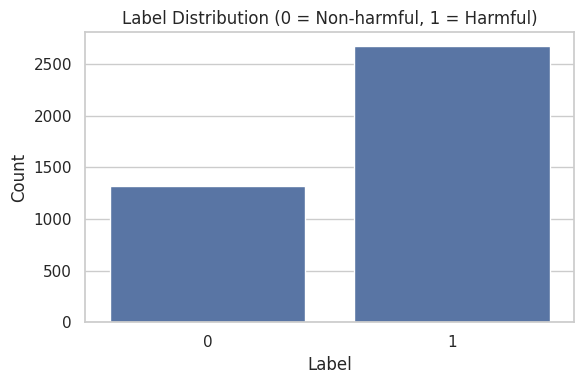

In [ ]:
# Bar plot of label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="label", data=df)
plt.title("Label Distribution (0 = Non-harmful, 1 = Harmful)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

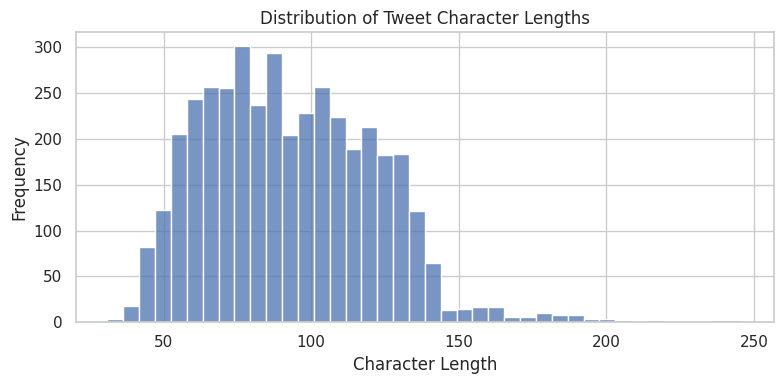

In [ ]:
# Create a column with character length of text
df["char_len"] = df["text"].astype(str).str.len()

# Histogram of tweet character lengths
plt.figure(figsize=(8, 4))
sns.histplot(df["char_len"], bins=40)
plt.title("Distribution of Tweet Character Lengths")
plt.xlabel("Character Length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

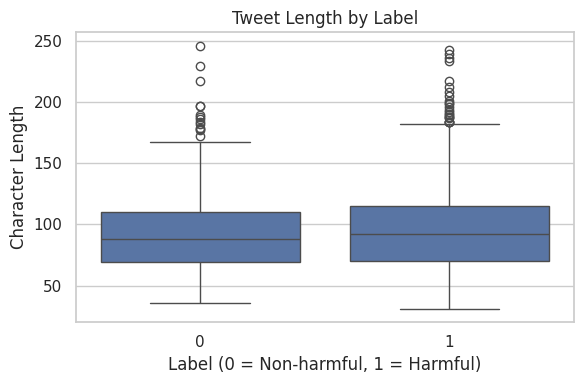

In [ ]:
# Boxplot of character length grouped by label
plt.figure(figsize=(6, 4))
sns.boxplot(x="label", y="char_len", data=df)
plt.title("Tweet Length by Label")
plt.xlabel("Label (0 = Non-harmful, 1 = Harmful)")
plt.ylabel("Character Length")
plt.tight_layout()
plt.show()

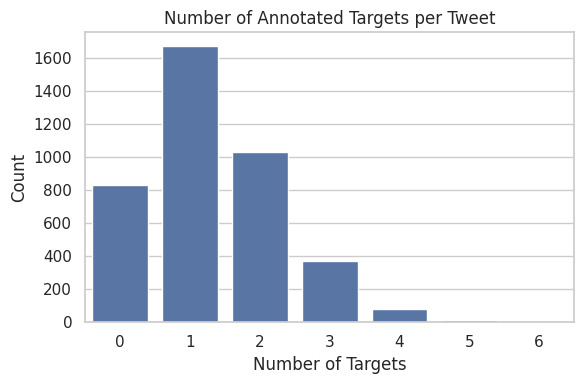

In [ ]:
# List of target columns
target_cols = ["T1 Target", "T2 Target", "T3 Target", "T4 Target", "T5 Target", "T6 Target"]
df["num_targets"] = df[target_cols].notna().sum(axis=1)

# Barplot of number of targets
plt.figure(figsize=(6, 4))
sns.countplot(x="num_targets", data=df)
plt.title("Number of Annotated Targets per Tweet")
plt.xlabel("Number of Targets")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
# Create a simple lowercase text column for Bag-of-Words
df["text_lower"] = df["text"].astype(str).str.lower()

In [ ]:
# Split data into harmful and non-harmful text
text_non_harmful = df[df["label"] == 0]["text_lower"]
text_harmful = df[df["label"] == 1]["text_lower"]

In [ ]:
# Use CountVectorizer to get word counts for non-harmful tweets
vectorizer_non = CountVectorizer(stop_words="english", max_features=50)
X_non = vectorizer_non.fit_transform(text_non_harmful)
non_word_sums = np.asarray(X_non.sum(axis=0)).flatten()
non_vocab = np.array(vectorizer_non.get_feature_names_out())

In [ ]:
# Get indices of top 20 words for non-harmful tweets
top_non_indices = non_word_sums.argsort()[::-1][:20]
top_non_words = non_vocab[top_non_indices]
top_non_counts = non_word_sums[top_non_indices]

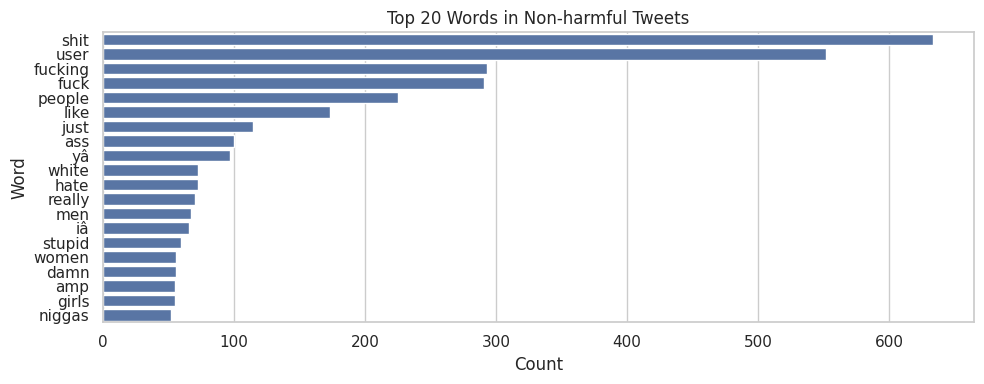

In [ ]:
# Plot top 20 words for non-harmful tweets
plt.figure(figsize=(10, 4))
sns.barplot(x=top_non_counts, y=top_non_words)
plt.title("Top 20 Words in Non-harmful Tweets")
plt.xlabel("Count")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

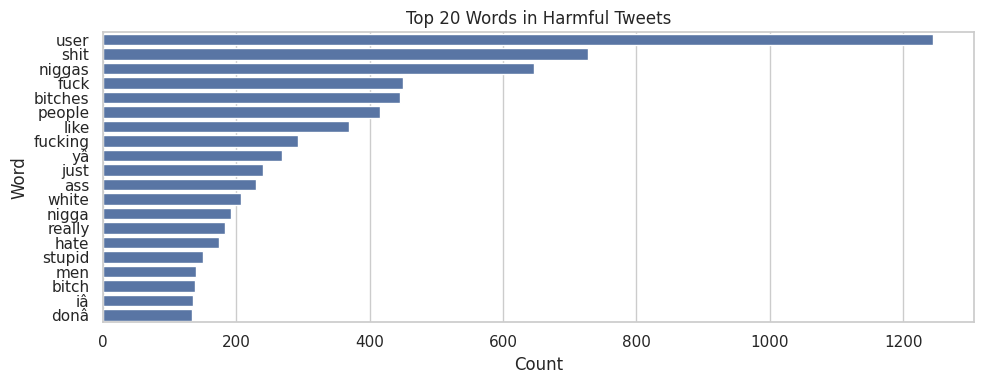

In [ ]:
# Use CountVectorizer to get word counts for harmful tweets
vectorizer_harm = CountVectorizer(stop_words="english", max_features=50)
X_harm = vectorizer_harm.fit_transform(text_harmful)
harm_word_sums = np.asarray(X_harm.sum(axis=0)).flatten()
harm_vocab = np.array(vectorizer_harm.get_feature_names_out())

# Get indices of top 20 words for harmful tweets
top_harm_indices = harm_word_sums.argsort()[::-1][:20]
top_harm_words = harm_vocab[top_harm_indices]
top_harm_counts = harm_word_sums[top_harm_indices]

# Plot top 20 words for harmful tweets
plt.figure(figsize=(10, 4))
sns.barplot(x=top_harm_counts, y=top_harm_words)
plt.title("Top 20 Words in Harmful Tweets")
plt.xlabel("Count")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

### Pre-Processing

In [ ]:
# Creating a new cleaned text column with basic regex-based cleaning
df["clean_text"] = df["text"].astype(str).str.lower()

In [ ]:
# Remove @mentions
df["clean_text"] = df["clean_text"].str.replace(r"@\w+", " ", regex=True)

In [ ]:
# Remove URLs
df["clean_text"] = df["clean_text"].str.replace(r"http\S+|www\.\S+", " ", regex=True)

In [ ]:
# Remove non-alphanumeric characters
df["clean_text"] = df["clean_text"].str.replace(r"[^a-z0-9\s]", " ", regex=True)

In [ ]:
# Collapse multiple spaces into one
df["clean_text"] = df["clean_text"].str.replace(r"\s+", " ", regex=True).str.strip()

In [ ]:
# cleaned data
print("Sample cleaned text:")
df[["text", "clean_text"]].head()

Sample cleaned text:


,text,clean_text
0,@USER Love it keep up the good work sunshine b...,love it keep up the good work sunshine big or ...
1,Lmaooo yâall got other women telling yâall...,lmaooo y all got other women telling y all tha...
2,@USER I feel that sis. They needa begin deacti...,i feel that sis they needa begin deactivating ...
3,"all ""rivalry's"" and shit talking aside im so h...",all rivalry s and shit talking aside im so hap...
4,Black musicians think they have to say a bunch...,black musicians think they have to say a bunch...


In [ ]:
# Features (clean text) and labels
X_text = df["clean_text"]
y = df["label"].astype(int)

In [ ]:
# Split into train and test sets
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42, stratify=y)

print("\nTrain size:", X_train_text.shape[0])
print("Test size:", X_test_text.shape[0])


Train size: 3199
Test size: 800


* TOKENIZER & PADDING FOR BiLSTM

In [ ]:
# Define vocabulary size and maximum sequence length
max_words = 20000
max_len = 40

# Initialize Keras Tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")

# Fit tokenizer on training text
tokenizer.fit_on_texts(X_train_text)

In [ ]:
# Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

In [ ]:
# Pad sequences to fixed length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post", truncating="post")

print("Example padded sequence:")
print(X_train_pad[0])


Example padded sequence:
[   2  251  193   49   11 2571   24   10    7  273   17   44  102  362
   20   34  108    7  107   23   20   19    2 1723    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


### Bilstm Model

In [ ]:
# Build BiLSTM Model
bilstm_model = Sequential()
# Embedding layer with explicit input shape
bilstm_model.add(Embedding(input_dim=max_words,output_dim=128,input_length=max_len,trainable=True))
# Bidirectional LSTM
bilstm_model.add(Bidirectional(LSTM(128, return_sequences=False)))
# Dropout
bilstm_model.add(Dropout(0.5))
# Hidden dense layer
bilstm_model.add(Dense(64, activation="relu"))
# More dropout
bilstm_model.add(Dropout(0.5))
# Output layer (binary classification)
bilstm_model.add(Dense(1, activation="sigmoid"))

In [ ]:
# Build model with explicit input shape
bilstm_model.build(input_shape=(None, max_len))

In [ ]:
# Compile the model
bilstm_model.compile(loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"])

In [ ]:
# Model Summary
print("\nBiLSTM Model Summary:")
print(bilstm_model.summary())


BiLSTM Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 40, 128)        │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,839,681 (10.83 MB)

 Trainable params: 2,839,681 (10.83 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# TRAIN BiLSTM MODEL
bilstm_history = bilstm_model.fit(
    X_train_pad,y_train.values,epochs=5,
    batch_size=64,validation_split=0.2,
    verbose=1)

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.6519 - loss: 0.6577 - val_accuracy: 0.6578 - val_loss: 0.6316
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6855 - loss: 0.5878 - val_accuracy: 0.6812 - val_loss: 0.5769
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7667 - loss: 0.4440 - val_accuracy: 0.6984 - val_loss: 0.6069
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8820 - loss: 0.2979 - val_accuracy: 0.6797 - val_loss: 0.7462
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9395 - loss: 0.1697 - val_accuracy: 0.6797 - val_loss: 1.0501


In [ ]:
# EVALUATE BiLSTM
bilstm_probs = bilstm_model.predict(X_test_pad)
bilstm_preds = (bilstm_probs >= 0.5).astype(int).flatten()

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
# Classification Report for BiLSTM
print("BiLSTM Classification Report:")
print(classification_report(y_test, bilstm_preds, digits=4))


BiLSTM Classification Report:
              precision    recall  f1-score   support

           0     0.5438    0.4453    0.4896       265
           1     0.7479    0.8150    0.7800       535

    accuracy                         0.6925       800
   macro avg     0.6458    0.6301    0.6348       800
weighted avg     0.6803    0.6925    0.6838       800



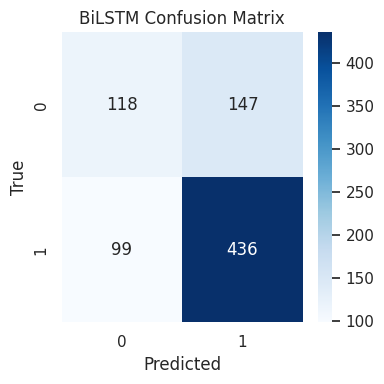

In [ ]:
# Confusion Matrix
bilstm_cm = confusion_matrix(y_test, bilstm_preds)
plt.figure(figsize=(4, 4))
sns.heatmap(bilstm_cm, annot=True, fmt="d", cmap="Blues")
plt.title("BiLSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

BERT TOKENIZATION & DATASETS

In [ ]:
# Initialize BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Encode train texts
train_encodings = bert_tokenizer(list(X_train_text),
    truncation=True,padding=True,
    max_length=64,return_tensors="tf")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [ ]:
# Encode test texts
test_encodings = bert_tokenizer(
    list(X_test_text),
    truncation=True,
    padding=True,
    max_length=64,
    return_tensors="tf"
)

In [ ]:
# Convert labels to tensors
y_train_tensor = tf.constant(y_train.values)
y_test_tensor = tf.constant(y_test.values)

In [ ]:
# Create tf.data.Dataset for training and testing
train_dataset = tf.data.Dataset.from_tensor_slices(
    (dict(train_encodings), y_train_tensor)
).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (dict(test_encodings), y_test_tensor)
).batch(16)

* BUILD BERT MODEL

In [ ]:
# Load BERT model for binary sequence classification
bert_model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    use_safetensors=False
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import AdamWeightDecay

# Compile BERT model with suitable optimizer and loss
bert_model.compile(
    optimizer=AdamWeightDecay(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

In [ ]:
# Train BERT model
bert_history = bert_model.fit(train_dataset,epochs=5,validation_data=test_dataset)

Epoch 1/5
200/200 [==============================] - 87s 255ms/step - loss: 0.5673 - accuracy: 0.6987 - val_loss: 0.5497 - val_accuracy: 0.6662
Epoch 2/5
200/200 [==============================] - 46s 230ms/step - loss: 0.4675 - accuracy: 0.7715 - val_loss: 0.5914 - val_accuracy: 0.6712
Epoch 3/5
200/200 [==============================] - 46s 230ms/step - loss: 0.3410 - accuracy: 0.8546 - val_loss: 0.8371 - val_accuracy: 0.6413
Epoch 4/5
200/200 [==============================] - 46s 229ms/step - loss: 0.2461 - accuracy: 0.9022 - val_loss: 0.7886 - val_accuracy: 0.6900
Epoch 5/5
200/200 [==============================] - 46s 229ms/step - loss: 0.1798 - accuracy: 0.9322 - val_loss: 0.9558 - val_accuracy: 0.7350


* EVALUATE BERT MODEL

In [ ]:
# Get predictions from BERT model on test dataset
bert_logits = bert_model.predict(test_dataset).logits

# Take argmax over logits to get predicted class (0 or 1)
bert_preds = tf.argmax(bert_logits, axis=1).numpy()

50/50 [==============================] - 6s 70ms/step


In [ ]:
# Print classification report for BERT
print("\nBERT Classification Report:")
print(classification_report(y_test, bert_preds, digits=4))


BERT Classification Report:
              precision    recall  f1-score   support

           0     0.6280    0.4906    0.5508       265
           1     0.7723    0.8561    0.8121       535

    accuracy                         0.7350       800
   macro avg     0.7002    0.6733    0.6815       800
weighted avg     0.7245    0.7350    0.7255       800



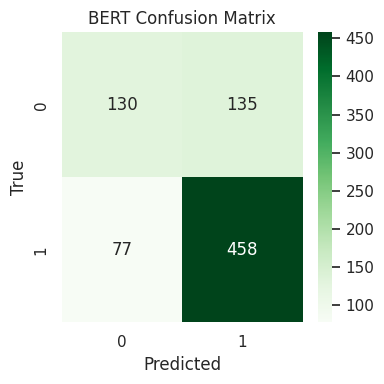

In [ ]:
# Plot confusion matrix for BERT
bert_cm = confusion_matrix(y_test, bert_preds)
plt.figure(figsize=(4, 4))
sns.heatmap(bert_cm, annot=True, fmt="d", cmap="Greens")
plt.title("BERT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

### Model Comparision

In [ ]:
# classification reports as dictionaries
bilstm_report = classification_report(y_test, bilstm_preds, output_dict=True)
bert_report = classification_report(y_test, bert_preds, output_dict=True)

# Extract relevant metrics
bilstm_accuracy = bilstm_report['accuracy']
bilstm_macro_f1 = bilstm_report['macro avg']['f1-score']
bilstm_macro_precision = bilstm_report['macro avg']['precision']
bilstm_macro_recall = bilstm_report['macro avg']['recall']

bert_accuracy = bert_report['accuracy']
bert_macro_f1 = bert_report['macro avg']['f1-score']
bert_macro_precision = bert_report['macro avg']['precision']
bert_macro_recall = bert_report['macro avg']['recall']

In [ ]:
# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Model': ['BiLSTM', 'BERT'],
    'Accuracy': [bilstm_accuracy, bert_accuracy],
    'Macro Avg Precision': [bilstm_macro_precision, bert_macro_precision],
    'Macro Avg Recall': [bilstm_macro_recall, bert_macro_recall],
    'Macro Avg F1-Score': [bilstm_macro_f1, bert_macro_f1]})

In [ ]:
print("Model Comparison Table:")
comparison_df

Model Comparison Table:


,Model,Accuracy,Macro Avg Precision,Macro Avg Recall,Macro Avg F1-Score
0,BiLSTM,0.6925,0.645817,0.630118,0.634795
1,BERT,0.7350,0.700182,0.673320,0.681452


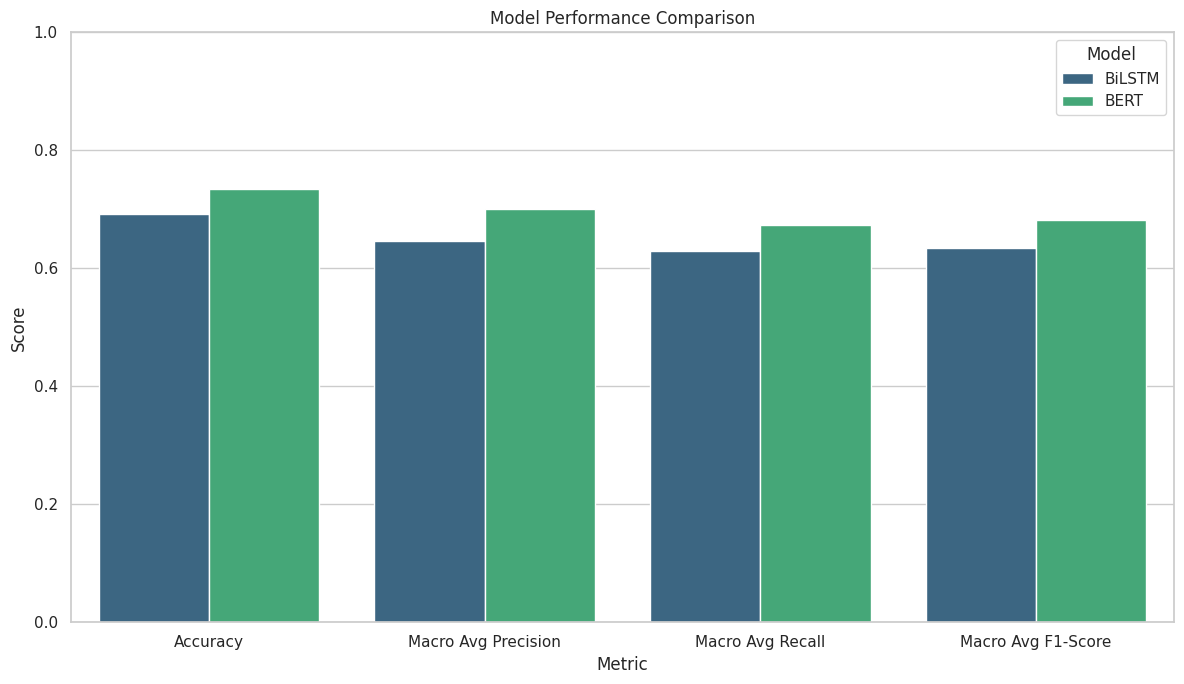

In [ ]:
# Create a bar plot for comparison
metrics_to_plot = ['Accuracy', 'Macro Avg Precision', 'Macro Avg Recall', 'Macro Avg F1-Score']
plot_df = comparison_df[['Model'] + metrics_to_plot].melt('Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.barplot(x='Metric', y='Score', hue='Model', data=plot_df, palette='viridis')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.tight_layout()
plt.show()